In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120
import numba

import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import optimizers

from IPython.display import clear_output

from PIL import Image

In [2]:
def genTrainingImages(imgSize, N, minCircles=1, maxCircles=4, minRadius=125, maxRadius=200, overlap=False, noise=1):
    img = np.zeros((N, *imgSize))
    numCircles = np.random.randint(minCircles, maxCircles, size=N)
    
    circleCentersX = np.random.randint(0, imgSize[0], size=N)
    circleCentersY = np.random.randint(0, imgSize[1], size=N)
    
    Y = np.arange(imgSize[0]).reshape((imgSize[0], 1)) # Column vector
    X = np.arange(imgSize[1]).reshape((1, imgSize[1])) # Row vector
    
    # Generate the circles
    for i in range(N):
        radii = np.random.uniform(minRadius, maxRadius, size=numCircles[i])
        j = 0
        while j < numCircles[i]:
            yC, xC = np.random.randint(0, imgSize[0]), np.random.randint(0, imgSize[1])
            newCircle = ((X - xC)**2 + (Y - yC)**2) < radii[j]**2
            # Make sure circles don't overlap
            if np.max(img[i] + newCircle) == 1:
                img[i] += newCircle
                j += 1
                
    # Now add noise
    noisyImg = img + np.random.uniform(0.01*noise, noise, size=img.shape)
    
    return noisyImg, img

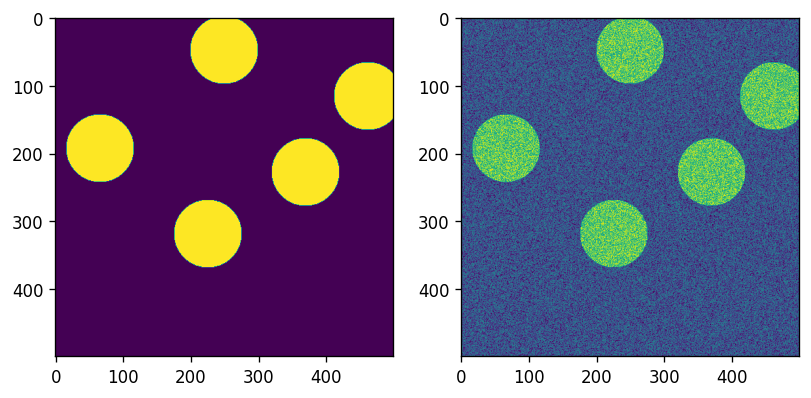

In [15]:
noisyImg, img = genTrainingImages((500, 500), 3, 5, 6, 50, 50, noise=1)

for i in range(len(noisyImg)):
    Image.fromarray(255*(1-noisyImg[i]).convert('L').save(f'../test_circles_{i+1}.bmp')

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(img[0])
ax[1].imshow(noisyImg[0])
plt.show()

In [4]:
# Set up the neural network
network = Sequential()

# 5x5 kernel size, 10 channels in first hidden layer:
network.add(Conv2D(32, 11, input_shape=(None,None,1),
               activation="relu", padding='same'))

# 5x5 kernel size, 10 channels
network.add(Conv2D(64, 11, activation="relu", padding='same'))
# 5x5 kernel size, 5 channels
network.add(Conv2D(64, 11, activation="relu", padding='same'))
# 5x5 kernel size, 5 channels
network.add(Conv2D(32, 11, activation="relu", padding='same'))

# 5x5 kernel size, only 1 channel in last hidden layer:
network.add(Conv2D(1, 11, activation="sigmoid", padding='same'))

network.compile(loss='mean_squared_error', optimizer='adam')

2022-03-16 10:35:15.050288: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 10:35:15.050337: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 10:35:15.050395: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eno.physics.ncsu.edu): /proc/driver/nvidia/version does not exist


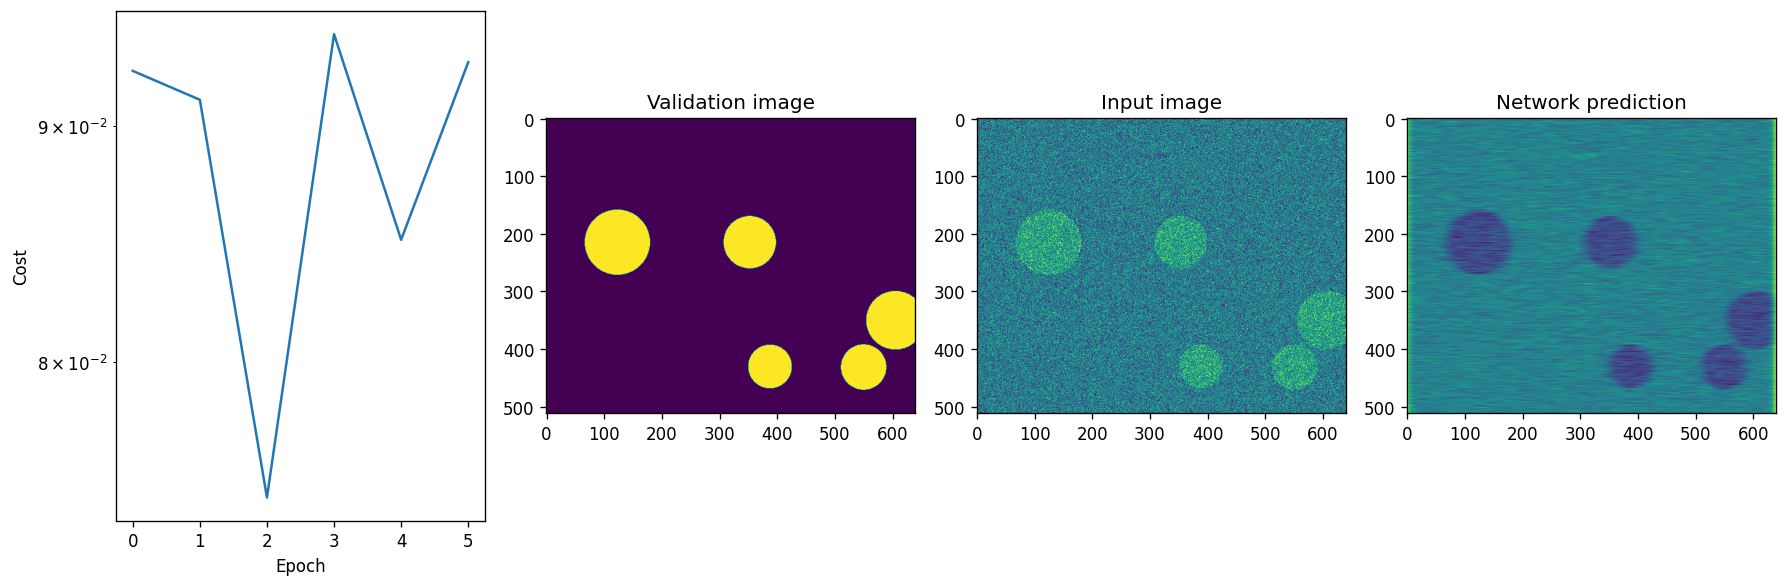

In [ ]:
batchSize = 30
epochs = 1000

costArr = np.zeros(epochs)

for i in range(epochs):
    noisyImg, img = genTrainingImages((512, 640), batchSize+1, noise=5, minRadius=30, maxRadius=60, minCircles=1, maxCircles=10)
    
    costArr[i] = network.train_on_batch(noisyImg[:-1], img[:-1])
    
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 4, figsize=(15,5))
    
    ax[0].plot(costArr[:i+1])
    ax[0].set_ylabel('Cost')
    ax[0].set_xlabel('Epoch')
    ax[0].set_yscale('log')
    
    ax[1].imshow(img[-1])
    ax[1].set_title('Validation image')
    
    ax[2].imshow(noisyImg[-1])
    ax[2].set_title('Input image')

    ax[3].imshow(network.predict(noisyImg[-1,:,:,None])[:,:,0,0])
    ax[3].set_title('Network prediction')
    
    fig.tight_layout()
    plt.savefig('cnn_detection_status.png')
    plt.show()